# 시뮬레이션 방법론 과제 1 

20249433 최재필 

In [10]:
import QuantLib as ql

import numpy as np
import scipy.stats as sst

import matplotlib.pyplot as plt


## 1. 베리어옵션 가격 계산

- A. 
    - Up vs Down
    - Out vs In
    - Call vs Put (총 2 * 2 * 2 = 8가지)
- B. 
    - 기초자산은 1개
    - 옵션 평가일의 기초자산 가격 S
    - GBM 프로세스 따름 
- C. 
    - 옵션 만기 T (year)
    - 만기까지 knock 여부 관측시점은 m번 ($ \Delta t = T / m $)
- D.
    - 옵션 베리어 B
    - 행사가격 K
    - 무위험 금리 (연속금리) r
    - 변동성 $ \sigma $
    - 배당 = 0
- E. 
    - replication 회수 n번

In [11]:
# Validate input

def check_option_types(barrier_type, option_type):

    barrier_type = barrier_type.lower()
    option_type = option_type.lower()

    assert barrier_type in ['upout', 'downout', 'upin', 'downin']
    assert option_type in ['call', 'put']

    return barrier_type, option_type

In [12]:
# Quantlib을 활용한 analytical solution (mcs와 비교용)

def barrier_option_QL(
        S, r, vol, T, K, B, rebate=0,
        barrier_type='upout',
        option_type='call'
        ):
    
    barrier_type, option_type = check_option_types(barrier_type, option_type)

    # Requires Python >= 3.10 for match-case syntax
    match barrier_type:
        case 'upout':
            barrier_type = ql.Barrier.UpOut
        case 'downout':
            barrier_type = ql.Barrier.DownOut
        case 'upin':
            barrier_type = ql.Barrier.UpIn
        case 'downin':
            barrier_type = ql.Barrier.DownIn
    
    match option_type:
        case 'call':
            option_type = ql.Option.Call
        case 'put':
            option_type = ql.Option.Put
    
    today = ql.Date.todaysDate()
    maturity = today + ql.Period(int(T*365), ql.Days)

    # barrier option
    payoff = ql.PlainVanillaPayoff(option_type, K)
    eu_exercise = ql.EuropeanExercise(maturity)
    barrier_option = ql.BarrierOption(barrier_type, B, rebate, payoff, eu_exercise)

    # market
    spot_handle = ql.QuoteHandle(ql.SimpleQuote(S))
    flat_rate_ts = ql.YieldTermStructureHandle(ql.FlatForward(today, r, ql.Actual365Fixed()))
    flat_vol_ts = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(today, ql.NullCalendar(), vol, ql.Actual365Fixed()))
    bsm_process = ql.BlackScholesProcess(spot_handle, flat_rate_ts, flat_vol_ts)
    analytic_engine = ql.AnalyticBarrierEngine(bsm_process)

    # pricing
    barrier_option.setPricingEngine(analytic_engine)

    return barrier_option.NPV()

In [13]:
# MCS

def barrier_option_MCS(
        S, r, vol, T, K, B, rebate=0,
        m=100, n=1000,
        barrier_type='upout',
        option_type='call',
        seed=42,
        ):
    
    barrier_type, option_type = check_option_types(barrier_type, option_type)

    np.random.seed(seed)

    ## Calculate price path

    dt = T / m # time step

    Z = np.random.randn(n, m) # n x m matrix of standard normal random variables

    drift = (r - 0.5 * vol**2) * dt
    diffusion = vol * np.sqrt(dt) * Z # n x m

    log_returns = drift + diffusion
    cum_log_returns = np.cumsum(log_returns, axis=1)

    S_t = S * np.exp(cum_log_returns)

    ## Calculate payoff

    is_call = 1 if option_type == 'call' else 0
    is_up = 1 if 'up' in barrier_type else 0
    is_in = 1 if 'in' in barrier_type else 0

    if is_up:
        barrier_breached = np.any(S_t >= B, axis=1)
    else: # down
        barrier_breached = np.any(S_t <= B, axis=1)
    
    if is_in:
        # Knock in 
        payoffs = np.where(
            barrier_breached,
            np.maximum(is_call * (S_t[:, -1] - K), 0),
            rebate
        )

    else: # out
        # Knock out
        payoffs = np.where(
            barrier_breached,
            rebate,
            np.maximum(is_call * (S_t[:, -1] - K), 0),
        )

    discounted_payoffs = np.exp(-r * T) * payoffs

    option_price = np.mean(discounted_payoffs)

    return option_price    

In [14]:
# Market Info
S = 100
r = 0.03
vol = 0.2

# Product Spec.
T = 1 # year
K = 100
B = 120

rebate = 0 # not needed

q = 0 # dividend yield, not needed
r = r - q

barrier_type = 'upout'
option_type = 'call'

# monte carlo simulation
m = 1000
n = 10000

In [15]:
# Compare

ql_price = barrier_option_QL(S, r, vol, T, K, B, rebate, barrier_type, option_type)
mcs_price = barrier_option_MCS(S, r, vol, T, K, B, rebate, m, n, barrier_type, option_type)

ql_price, mcs_price

(1.155369999815115, 1.211769817464179)

In [16]:
m = 10000
n = 10000

In [17]:
# Compare

ql_price = barrier_option_QL(S, r, vol, T, K, B, rebate, barrier_type, option_type)
mcs_price = barrier_option_MCS(S, r, vol, T, K, B, rebate, m, n, barrier_type, option_type)

ql_price, mcs_price

(1.155369999815115, 1.1796321912563104)

In [19]:
m = 100000
n = 1000

In [20]:
# Compare

ql_price = barrier_option_QL(S, r, vol, T, K, B, rebate, barrier_type, option_type)
mcs_price = barrier_option_MCS(S, r, vol, T, K, B, rebate, m, n, barrier_type, option_type)

ql_price, mcs_price

(1.155369999815115, 1.3708167725315024)

## 2. In-Out Parity


### In-Out Parity란

$$ 

call_{knock-in} + call_{knock-out} = call

$$ 

배리어를 나가던 말던 up-and-out(knock-out) 또는 up-and-in(knock-in) 둘 중 하나는 activate 되므로 둘을 합친 것은 항상 vanilla call이 되어야 한다는 parity. 

즉, 0 + c = c 또는 c + 0 = 0 이기에 성립한다는 것. 

출처: [Python for Finance](https://subscription.packtpub.com/book/data/9781783284375/11/ch11lvl1sec176/barrier-in-and-out-parity)


### MCS 옵션 평가에서 활용할 수 있는 방법

둘은 parity이므로 

- 우선 계산량이 적은 vanilla call의 가치를 먼저 mcs로 구하고 
- up-and-out 또는 up-and-in 둘 중 하나를 mcs로 구하면 
- 나머지 하나는 자동으로 구할 수 있어서 

up-and-out이랑 up-and-in 둘 모두의 가치를 구해야 할 때 계산을 덜할 수 있을 것 같다. 

심지어 생각해보니까 먼저 vanilla call 구할 때 price path는 만들어놓으니까 그 다음에 knock-in/out을 계산하면 되는거라서 vanilla 구하는건 어차피 knock-in/out 구하려면 필요한 것인 듯 하다. 

## 3. m, n과 bias, variance의 관계

m, n 변경시 bias, variance의 변화를 시뮬레이션 결과로 설명

- bias:
    - analytic solution의 실제 값과 simulation 결과 (의 평균) 사이의 차이
    - m을 늘려야 discretization error를 줄여 bias를 줄일 수 있다. 
    - 하지만 계속 늘리면 computation cost도 올라가고, 수업시간에도 무조건 늘리는게 좋지는 않다고 배움
- variance: 
    - simulation 결과들 사이의 차이
    - n을 늘려야 simulation들의 std를 줄여 variance를 줄일 수 있다. 
    - 늘릴수록 computation cost 올라감. 
    - --> variance가 이게 맞나? gpt한테 물어보니 `n_values`(예를 들어 10000번)는 monte carlo simulation 1번 할 때 생성하는 path의 갯수고 `n_simulations`(예를들어 30번), 즉 10000번짜리 simulation을 또 30번 돌려줘야 variance를 알 수 있다는데.
    - 교수님 답변:
        - N을 쓰는게 맞다. 


결론: 
- 한정된 연산 자원 내에서 m과 n 사이에 적절하게 분배를 해야한다. 
- 교수님 답변:
    - mean variance tradeoff를 그래프로 그려야 한다. 
    - y축이 mse, x축에 bias, variance를 모두 표시해서 그것이 일반적으로 알고있는 mean variance trade off 개형처럼 나오는지 확인한다. 

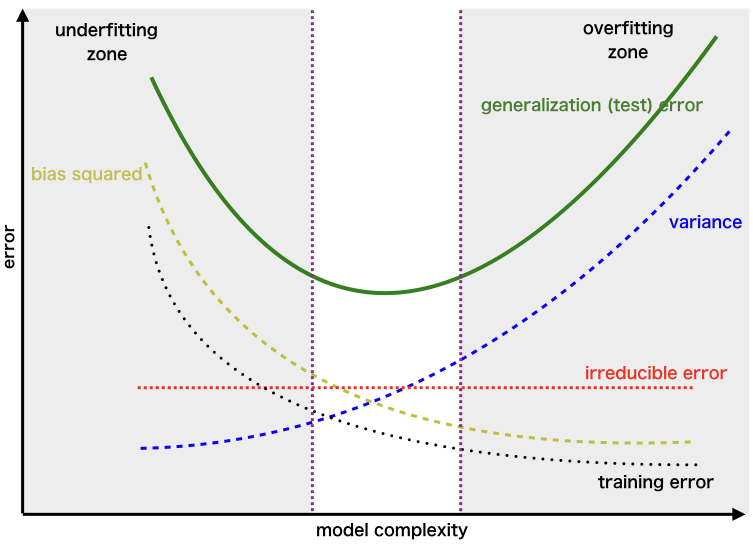

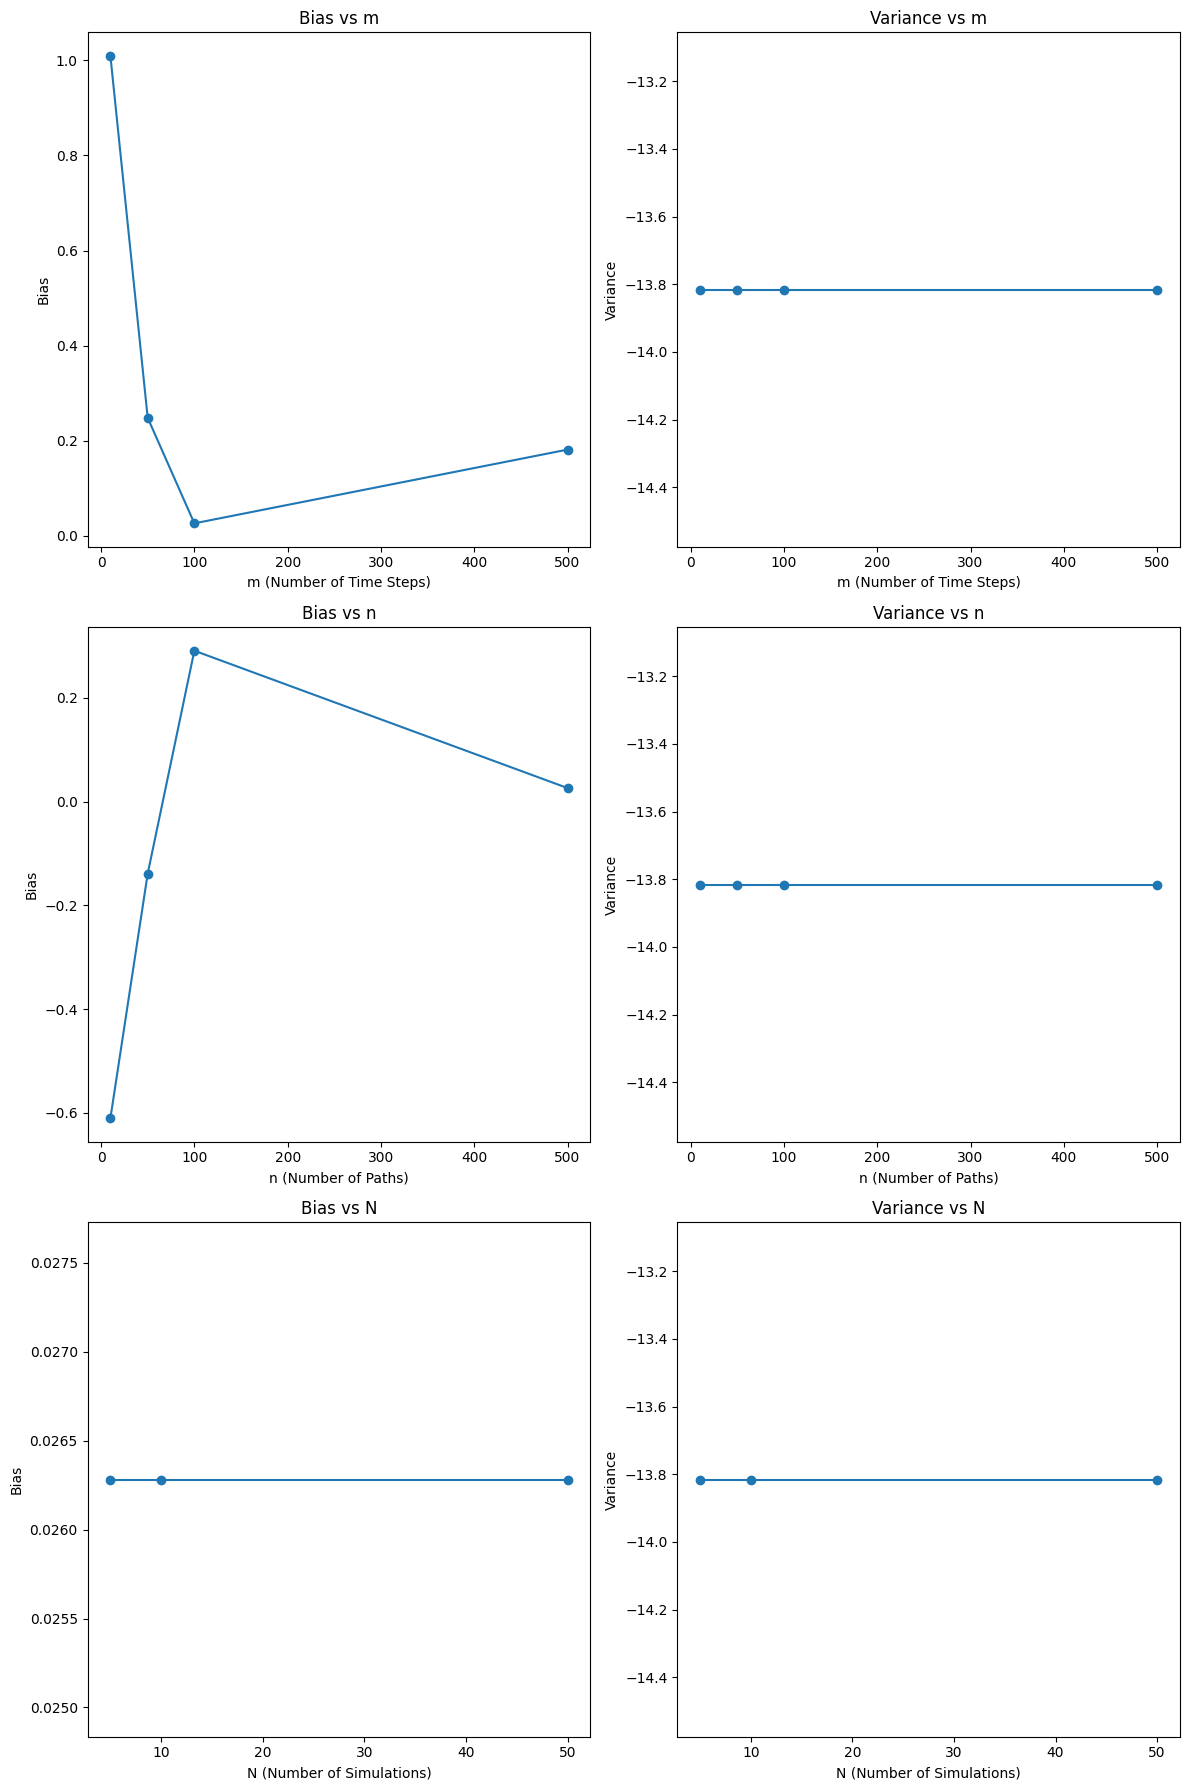

In [18]:
def simulate_and_plot(reference_price, m_values, n_values, N_values):
    S = 100
    r = 0.03
    vol = 0.2
    T = 1
    K = 100
    B = 120
    rebate = 0
    barrier_type = 'upout'
    option_type = 'call'

    # Bias and Variance for m_values
    biases_m = []
    variances_m = []
    for m in m_values:
        prices = [barrier_option_MCS(S, r, vol, T, K, B, rebate, m, 500, barrier_type, option_type) for _ in range(50)]
        biases_m.append(np.mean(prices) - reference_price)
        variances_m.append(np.var(prices))

    # Bias and Variance for n_values
    biases_n = []
    variances_n = []
    for n in n_values:
        prices = [barrier_option_MCS(S, r, vol, T, K, B, rebate, 100, n, barrier_type, option_type) for _ in range(50)]
        biases_n.append(np.mean(prices) - reference_price)
        variances_n.append(np.var(prices))

    # Bias and Variance for N_values
    biases_N = []
    variances_N = []
    for N in N_values:
        prices = [barrier_option_MCS(S, r, vol, T, K, B, rebate, 100, 500, barrier_type, option_type) for _ in range(N)]
        biases_N.append(np.mean(prices) - reference_price)
        variances_N.append(np.var(prices))

    # variance 너무 작아 눈에 잘 안띈다. log scale로 변환
    # 너무 작아 0 division error 나니까 std로 변환
    # sqrt 씌워도 오류나네. epsilon 더해주자. 

    epsilon = 1e-12

    variances_m = np.array(variances_m)
    variances_n = np.array(variances_n)
    variances_N = np.array(variances_N)

    variances_m = np.log(np.sqrt(variances_m + epsilon)) # std임
    variances_n = np.log(np.sqrt(variances_n + epsilon)) # std임
    variances_N = np.log(np.sqrt(variances_N + epsilon)) # std임

    # Plotting
    fig, axs = plt.subplots(3, 2, figsize=(12, 18))

    axs[0, 0].plot(m_values, biases_m, marker='o')
    axs[0, 0].set_title('Bias vs m')
    axs[0, 0].set_xlabel('m (Number of Time Steps)')
    axs[0, 0].set_ylabel('Bias')

    axs[0, 1].plot(m_values, variances_m, marker='o')
    axs[0, 1].set_title('Variance vs m')
    axs[0, 1].set_xlabel('m (Number of Time Steps)')
    axs[0, 1].set_ylabel('Variance')

    axs[1, 0].plot(n_values, biases_n, marker='o')
    axs[1, 0].set_title('Bias vs n')
    axs[1, 0].set_xlabel('n (Number of Paths)')
    axs[1, 0].set_ylabel('Bias')

    axs[1, 1].plot(n_values, variances_n, marker='o')
    axs[1, 1].set_title('Variance vs n')
    axs[1, 1].set_xlabel('n (Number of Paths)')
    axs[1, 1].set_ylabel('Variance')

    axs[2, 0].plot(N_values, biases_N, marker='o')
    axs[2, 0].set_title('Bias vs N')
    axs[2, 0].set_xlabel('N (Number of Simulations)')
    axs[2, 0].set_ylabel('Bias')

    axs[2, 1].plot(N_values, variances_N, marker='o')
    axs[2, 1].set_title('Variance vs N')
    axs[2, 1].set_xlabel('N (Number of Simulations)')
    axs[2, 1].set_ylabel('Variance')

    plt.tight_layout()
    plt.show()

# Example usage
reference_price = ql_price  # Replace with the actual reference price
m_values = [10, 50, 100, 500]
n_values = [10, 50, 100, 500]
N_values = [5, 10, 50]

simulate_and_plot(reference_price, m_values, n_values, N_values)

결과 해석: 

- 고정값들: 
    - n = 500
    - m = 100
    - N = 50
- bias: 
    - m을 늘릴 때
        - 점점 0 근처로 떨어짐
        - 근데 다시 올라감. (너무 step을 작게 잡아서인가? )
    - n을 늘릴 때
        - 그래프는 오르는 것처럼 보이나, 그게 아니라 0 근처로 가고 있는 것임.
        - n도 늘릴수록 bias가 줄어듦
    - N을 늘릴 때
        - 변화 없음. 딱 거의 0. 
- variance:
    - 로그스케일
    - 모두 0에서 변화 없음. (1e-13은 0-division 방지 epsilon 값)